In [1]:
from pathlib import Path 
import numpy as np
import pandas as pd
# from tqdm import tqdm
import matplotlib.pyplot as plt
# import seaborn as sns
import unicodedata
import matplotlib.font_manager as fm
import japanize_matplotlib  # ←簡単に日本語を使えるようにする方法


In [2]:
# data_folder_name = '2503-05'
data_folder_name = '2407-09'
data_folder_path = Path('./data')

select_folder_path = data_folder_path / data_folder_name
result_folder_path = select_folder_path / '__Result__'
result_folder_path.mkdir(exist_ok=True)


In [3]:
data_folder_dir = [p for p in select_folder_path.iterdir()]
data_folder_dir = data_folder_dir[:-1]

In [4]:
# === 商品名の表記統一マップ ===
name_map = {
    'アメリカーノ': 'AC',
    'AC_シングル': 'AC',
    'AC W': 'AC_W',
    'AC_ダブル': 'AC_W',
    'IAC_シングル': 'IAC',
    'IAC_ダブル': 'IAC_W',

    'ESP_シングル': 'ESP',
    'ESP_ダブル': 'ESP_W',
    'ESP W': 'ESP_W',
    'カプチーノ': 'カプチ',
    'キャララテ': 'キャラメルラテ',
    'Iキャララテ': 'キャラメルラテ',
    'エスプレッソトニック': 'ESPトニック',
    'lデカフェラテ': 'Iデカフェラテ',

    'アールグレイ': 'ET_ストレート',
    'ET_ICE': 'IET_ストレート',
    'IET': 'IET_ストレート',
    'IEST': 'IET_ストレート',
    'ET_ICE レモン': 'IET_レモン',
    'ET_ICEミルク': 'IET_ミルク',
    'EST': 'ET_ストレート',
    'IST': 'IST_ストレート',
    'ST_ILT': 'IST_レモン',
    'ST_IMT': 'IST_ミルク',
    'ST_IST': 'IST_ストレート',


    'ゆず茶': 'ゆず',
    'Iゆず茶': 'Iゆず',

    'Iロイヤル': 'IRMT',
    'ロイヤル': 'RMT',

    'IGT': 'GT',
    'IGTO': 'GTO',

    '抹ラテ': '抹茶ラテ',
    'I抹ラテ': 'I抹茶ラテ',

    'バナナJ': 'バナJ',
    'バナナジュース': 'バナJ',

    'レモネードソーダ': 'レモソーダ',
    'レモネソーダ': 'レモソーダ',

    '豆乳変更': '豆乳',
}

In [ ]:
def load_csv(files_path):
    for i, path in enumerate(files_path):
        if i == 0:
            df = pd.read_csv(path, usecols=[0, 1, 2, 9], encoding="shift-jis")
        else:
            df = pd.concat([df, pd.read_csv(path, usecols=[0, 1, 2, 9], encoding="shift-jis")])

    return  df



def normalization(df):

    df['商品名'] = df['商品名'].apply(lambda x: unicodedata.normalize('NFKC', str(x)) if pd.notna(x) else x)

    # === 商品名が「☆」のみの場合は種別1を商品名に移す ===
    mask = df['商品名'].astype(str).str.strip() == '☆'
    df.loc[mask & df['種別1'].notna(), '商品名'] = df.loc[mask & df['種別1'].notna(), '種別1']
    df.loc[mask, '種別1'] = np.nan

    # === 商品名の先頭にある "ICE" "I " を "I" に変換 ===
    df['商品名'] = df['商品名'].astype(str).str.replace(r'^ICE+', 'I', regex=True)
    df['商品名'] = df['商品名'].astype(str).str.replace(r'^I +', 'I', regex=True)

    # === 商品名の先頭にある "HOT" "H" を削除 ===
    df['商品名'] = df['商品名'].astype(str).str.replace(r'^HOT+', '', regex=True)
    df['商品名'] = df['商品名'].astype(str).str.replace(r'^H+', '', regex=True)


    # 不要な商品名のパターンを除外
    words = ['カレー', 'タコ', 'クラム', 'ハーフ', 'トースト']
    pattern = '|'.join(words)
    df = df[~df['商品名'].astype(str).str.contains(pattern, na=False)].copy()

    # 種別1の特定ワードを削除
    words = ['食事と共', '食後', ]
    pattern = '|'.join(words)
    if '種別1' in df.columns:
        mask = df['種別1'].notna()
        df['種別1'] = df['種別1'].astype(object)
        df.loc[mask, '種別1'] = df.loc[mask, '種別1'].astype(str).str.replace(pattern, '', regex=True)

    type_cols = ['種別1', '種別2']
    for col in type_cols:
        if col in df.columns:
            # === ICE ===
            ice_mask = df[col].astype(str).str.upper().isin(['ICE', 'I'])
            df.loc[ice_mask, '商品名'] = 'I' + df.loc[ice_mask, '商品名'].astype(str)
            df.loc[ice_mask, col] = np.nan

            # === HOT ===
            hot_mask = df[col].astype(str).str.upper().isin(['HOT', 'H'])
            df.loc[hot_mask, col] = np.nan

            # === 「◯◯あり／なし／有り／無し」パターンの削除 ===
            delete_pattern = r'.*(?:あり|なし|有り|無し|少なめ)$'
            delete_mask = df[col].astype(str).str.contains(delete_pattern, na=False)
            df.loc[delete_mask, col] = np.nan


    # === ICの表記統一 ===
    df['商品名'] = df['商品名'].replace('IBC', 'IC')


    # === 紅茶（ET系 / ST系）の組み合わせパターン変換 ===
    tea_map = {
        ('ET', 'ET'):  'ET_ストレート',
        ('ET', None):  'ET_ストレート',
        ('ET', 'ELT'): 'ET_レモン',
        ('ET', 'EMT'): 'ET_ミルク',
        ('ST', 'ST'):  'ST_ストレート',
        ('ST', None):  'ST_ストレート',
        ('ST', 'LT'):  'ST_レモン',
        ('ST', 'MT'):  'ST_ミルク',
        ('HOT アールグレイ', None): 'ET_ストレート',
        ('HOT アメリカーノ', None): 'AC',
    }

    for (base_name, subtype), new_name in tea_map.items():
        if subtype is None:
            mask = (df['商品名'] == base_name) & (df['種別1'].isna())
        else:
            mask = (df['商品名'] == base_name) & (df['種別1'] == subtype)
        df.loc[mask, '商品名'] = new_name
        df.loc[mask, ['種別1', '種別2']] = np.nan


    
    return df



def preprocessing(row):
    parts = []

    # 商品名（NaN でないもののみ）
    if pd.notna(row['商品名']):
        parts.append(str(row['商品名']).replace('☆', '').strip())

    # 種別1（NaNでも空文字でもないもの）
    if '種別1' in row and pd.notna(row['種別1']) and row['種別1'].strip() and row['種別1'] != row['商品名']:
        parts.append(row['種別1'].strip())

    # 種別2（NaNでも空文字でもないもの）
    if '種別2' in row and pd.notna(row['種別2']) and row['種別2'].strip():
        parts.append(row['種別2'].strip())

    return '_'.join(parts)

In [6]:
# 1フォルダのみに使用（デバッグ用）
files = [q for q in data_folder_dir[1].iterdir()]

df = load_csv(files)

df = normalization(df)

df['商品名'] = df.apply(preprocessing, axis=1)


if '種別1' in df.columns:
    df.drop(columns=['種別1'], inplace=True)
if '種別2' in df.columns:
    df.drop(columns=['種別2'], inplace=True)

# 商品名の正規化（前処理済みの状態に対してマップ）
df['商品名'] = df['商品名'].replace(name_map)

all_df = df

df_summary = all_df.groupby('商品名', as_index=False).sum()

# df_summary.to_csv(data_folder_dir[1]/'df_summary.csv',index= False, encoding="shift_jis")

      商品名  種別1  種別2  販売商品数
0      IC  NaN  NaN    141
1      BC  NaN  NaN     77
2     マンデ  NaN  NaN     38
3     Iモカ  NaN  NaN     10
4    Iマンデ  NaN  NaN      9
5    Iダーク  NaN  NaN      9
6     ダーク  NaN  NaN      9
7   Iブラジル  NaN  NaN      8
8   Iデカフェ  NaN  NaN      8
9      モカ  NaN  NaN      7
10   デカフェ  NaN  NaN      6
11   ブラジル  NaN  NaN      3
12  drink  NaN  NaN      1


In [50]:
df_summary

,商品名,販売商品数
0,AC,3
1,BC,21
2,ET_ストレート,5
3,GA,4
4,GT,3
5,GTO,3
6,IAC,4
7,IC,8
8,IEST,8
9,IO,4


In [64]:
# dataフォルダ内の全フォルダに適用（本命）

for j, dir_path in enumerate(data_folder_dir):
    files = [q for q in dir_path.iterdir()]
    
    df = load_csv(files)

    df = normalization(df)

    df['商品名'] = df.apply(preprocessing, axis=1)

    if '種別1' in df.columns:
        df.drop(columns=['種別1'], inplace=True)
    if '種別2' in df.columns:
        df.drop(columns=['種別2'], inplace=True)

    # 商品名の正規化（前処理済みの状態に対してマップ）
    df['商品名'] = df['商品名'].replace(name_map)

    df.to_csv(result_folder_path/f'{dir_path.name}.csv',index= False, encoding="shift_jis")

    if j == 0:
        all_df = df
    else:
        all_df = pd.concat([all_df, df], ignore_index=True)

df_summary = all_df.groupby('商品名', as_index=False).sum()
df_summary.to_csv(result_folder_path/f'__{data_folder_name}_df_summary.csv',index= False, encoding="shift_jis")



## 注文数上位10件

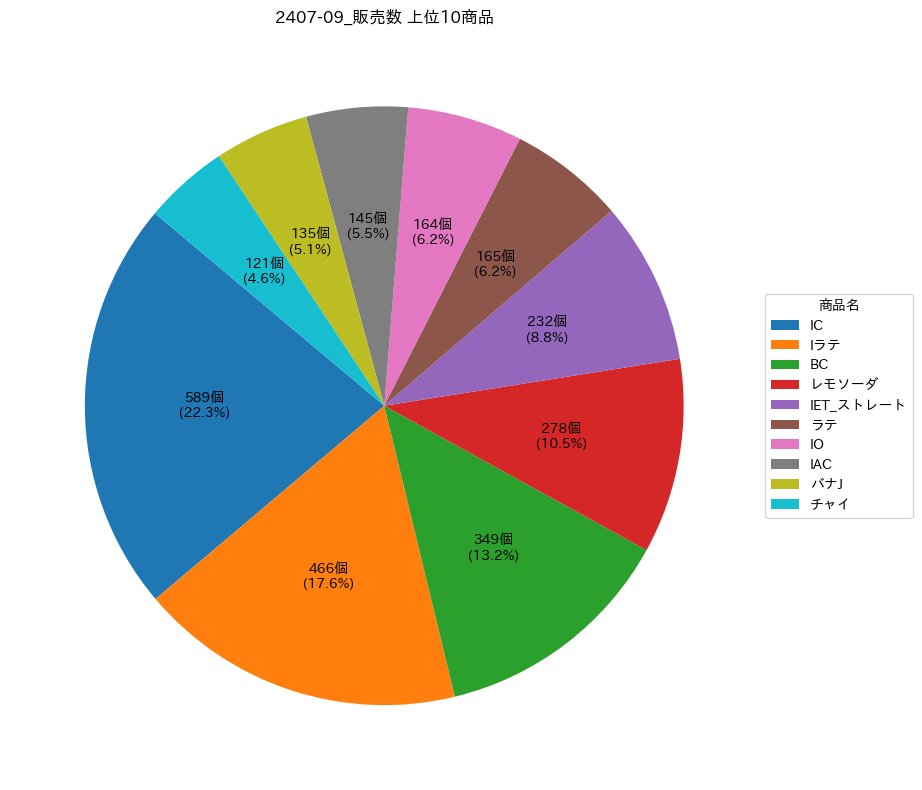

In [65]:
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語表示対応

# 上位15商品の取得（販売商品数順）
top15 = df_summary.sort_values('販売商品数', ascending=False).head(10)

# %と個数を同時に表示する関数
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'{val}個\n({pct:.1f}%)'
    return my_autopct

# 円グラフの描画
fig, ax = plt.subplots(figsize=(9, 8))
wedges, texts, autotexts = ax.pie(
    top15['販売商品数'],
    autopct=make_autopct(top15['販売商品数']),
    startangle=140
)

# 凡例の追加
ax.legend(wedges, top15['商品名'], title="商品名", loc="center left", bbox_to_anchor=(1, 0.5))

# タイトルとレイアウト調整
plt.title(f'{data_folder_name}_販売数 上位10商品')
plt.tight_layout()
plt.savefig(result_folder_path/f'__{data_folder_name}_pie_graph.png', dpi=300, bbox_inches='tight')
plt.show()




## コーヒー類のみ

In [66]:
coffee = {
    'BC': 'BC',
    'IC': 'BC',
    'ダーク': 'ダーク',
    'Iダーク': 'ダーク',
    'マンデ': 'マンデ',
    'Iマンデ': 'マンデ',
    'モカ': 'モカ',
    'Iモカ': 'モカ',
    'ブラジル': 'ブラジル',
    'Iブラジル': 'ブラジル',
    'デカフェ': 'デカフェ',
    'Iデカフェ': 'デカフェ',
    }

df_summary


,商品名,販売商品数
0,AC,85
1,BC,349
2,ESP,6
3,ESP_W,9
4,ESPトニック,40
...,...,...
62,レモソーダ,278
63,レモネード,19
64,抹茶(お菓子付き),23
65,抹茶ラテ,69


<Figure size 800x800 with 0 Axes>

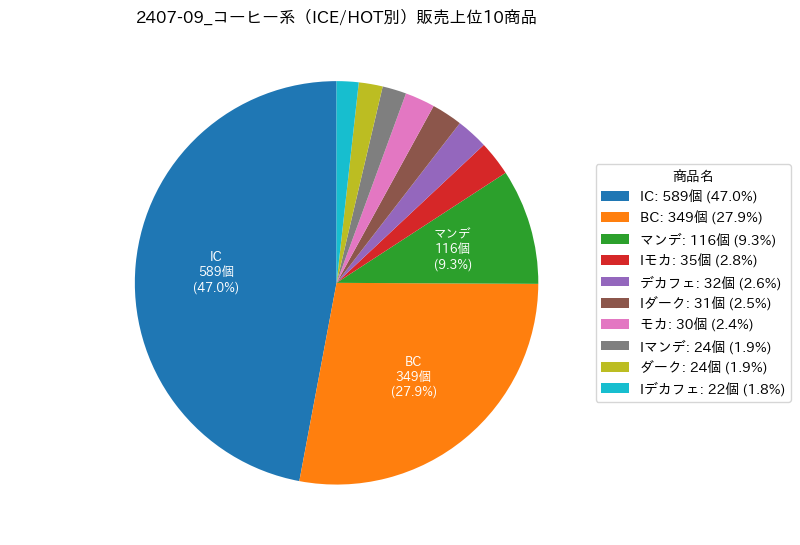

In [67]:
# coffeeに含まれる商品名のみ抽出
coffee_keys = list(coffee.keys())
coffee_df = df_summary[df_summary['商品名'].isin(coffee_keys)].copy()
coffee_df

# 販売数の多い順に上位10商品を取得
top10_coffee = coffee_df.sort_values('販売商品数', ascending=False).head(10)

# 上位10商品の合計販売数を計算
total = top10_coffee['販売商品数'].sum()

plt.figure(figsize=(8, 8))

# 各セクションの合計値と割合を含むラベルを作成
labels = [
    f"{row['商品名']}: {row['販売商品数']}個 ({row['販売商品数'] / top10_coffee['販売商品数'].sum():.1%})"
    for _, row in top10_coffee.iterrows()
]

# 円グラフを描画
fig, ax = plt.subplots(figsize=(8, 8))

# 円グラフ描画
wedges, texts, autotexts = ax.pie(
    top10_coffee['販売商品数'],
    labels=labels,
    startangle=90,
    autopct=lambda pct: '',  # 中央テキストを後で手動設定
    textprops=dict(color="white", fontsize=9)
)

# 上位3位は中央に商品名＋個数＋割合を表示
for i, autotext in enumerate(autotexts):
    if i < 3:
        pct = top10_coffee.iloc[i]['販売商品数'] / total * 100
        val = top10_coffee.iloc[i]['販売商品数']
        autotext.set_text(f"{top10_coffee.iloc[i]['商品名']}\n{val}個\n({pct:.1f}%)")
    else:
        autotext.set_text('')

# 凡例に情報を表示
plt.legend(wedges, labels, title="商品名", loc="center left", bbox_to_anchor=(1.0, 0.5))

plt.title(f'{data_folder_name}_コーヒー系（ICE/HOT別）販売上位10商品')
plt.tight_layout()
plt.savefig(result_folder_path/f'__{data_folder_name}_coffee_top10.png', dpi=300, bbox_inches='tight')
plt.show()

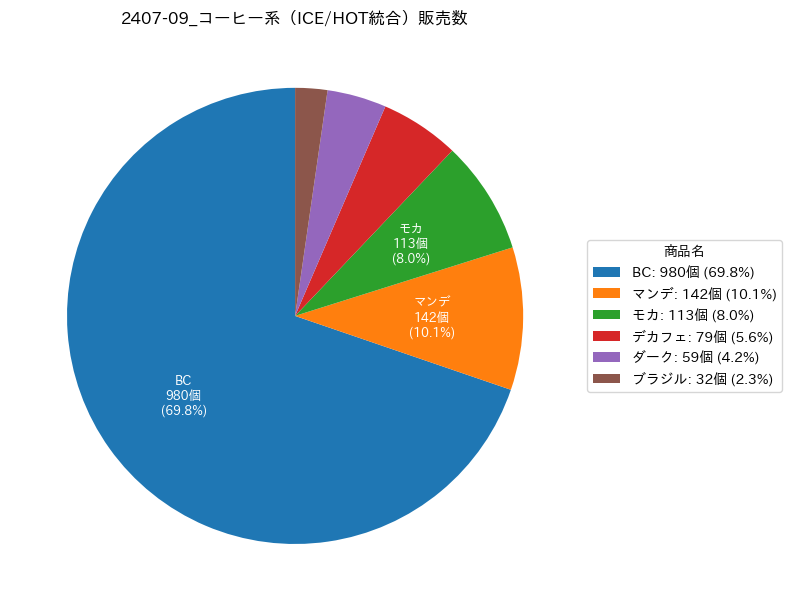

In [68]:
# coffee に含まれるキーワードが商品名に含まれているデータのみ抽出
def find_coffee_base(name):
    for key in coffee.keys():
        if key in name:
            return coffee[key]
    return None

# ベースカテゴリ列を追加
df_summary['coffee_base'] = df_summary['商品名'].apply(find_coffee_base)

# コーヒー系のみ抽出し、ベース名で集計
coffee_df_merged = df_summary[df_summary['coffee_base'].notna()].copy()
coffee_agg = coffee_df_merged.groupby('coffee_base', as_index=False)['販売商品数'].sum()

# 販売数の多い順に上位10商品を取得
top10_coffee = coffee_agg.sort_values('販売商品数', ascending=False).head(10)

# 合計販売数
total = top10_coffee['販売商品数'].sum()

# 描画開始
fig, ax = plt.subplots(figsize=(8, 8))

# ラベル作成（凡例用）
labels = [
    f"{row['coffee_base']}: {row['販売商品数']}個 ({row['販売商品数'] / total:.1%})"
    for _, row in top10_coffee.iterrows()
]

# 円グラフ
wedges, texts, autotexts = ax.pie(
    top10_coffee['販売商品数'],
    labels=None,
    startangle=90,
    autopct=lambda pct: '',
    textprops=dict(color="white", fontsize=9)
)

# 上位3位に中央にテキスト表示
for i, autotext in enumerate(autotexts):
    if i < 3:
        pct = top10_coffee.iloc[i]['販売商品数'] / total * 100
        val = top10_coffee.iloc[i]['販売商品数']
        name = top10_coffee.iloc[i]['coffee_base']
        autotext.set_text(f"{name}\n{val}個\n({pct:.1f}%)")
    else:
        autotext.set_text('')

# 凡例
ax.legend(
    wedges,
    labels,
    title="商品名",
    loc="center left",
    bbox_to_anchor=(1.0, 0.5),
    fontsize=10
)

ax.set_title(f'{data_folder_name}_コーヒー系（ICE/HOT統合）販売数')
plt.tight_layout()
plt.savefig(result_folder_path/f'__{data_folder_name}_coffee_top10_merged.png', dpi=300, bbox_inches='tight')
plt.show()